# Binary ECG Beat Classification - Final Stable Version

This notebook implements a stable, production-ready binary classifier for ECG beats:
- **Normal (0)**: Regular heartbeats
- **Irregular (1)**: Any abnormal heartbeat patterns

Features:
- Stable training with gradient clipping and L2 regularization
- Proper stratified data splits
- Comprehensive evaluation metrics
- Optional temperature scaling calibration
- Clean inference pipeline


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import json
import pickle
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)
from sklearn.utils import class_weight
from sklearn.calibration import calibration_curve
from scipy.optimize import minimize_scalar

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

# Configure plotting
sns.set_theme(style='whitegrid')
plt.rcParams.update({'figure.figsize': (10, 6)})

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")


2025-11-17 08:23:07.207279: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.16.2
NumPy version: 1.26.4


## 1. Dataset Setup


In [2]:
# Load data
DATA_DIR = Path('.')
X = np.load(DATA_DIR / 'X.npy').astype(np.float32)
y_raw = np.load(DATA_DIR / 'y.npy', allow_pickle=True)

print(f"Loaded X: {X.shape}")
print(f"Loaded y: {y_raw.shape}")
print(f"X dtype: {X.dtype}, y dtype: {y_raw.dtype}")

# Check unique labels
unique_labels, counts = np.unique(y_raw, return_counts=True)
print(f"\nUnique labels in raw data: {unique_labels}")
print("Label distribution:")
for label, count in zip(unique_labels, counts):
    pct = 100.0 * count / len(y_raw)
    print(f"  '{label}': {count} beats ({pct:.2f}%)")


Loaded X: (112551, 301, 2)
Loaded y: (112551,)
X dtype: float32, y dtype: object

Unique labels in raw data: ['-1' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Label distribution:
  '-1': 8 beats (0.01%)
  '0': 108321 beats (96.24%)
  '1': 2922 beats (2.60%)
  '2': 656 beats (0.58%)
  '3': 222 beats (0.20%)
  '4': 128 beats (0.11%)
  '5': 200 beats (0.18%)
  '6': 24 beats (0.02%)
  '7': 60 beats (0.05%)
  '8': 7 beats (0.01%)
  '9': 3 beats (0.00%)


In [3]:
# Convert multiclass labels to binary: 0 → 0 (normal), all others → 1 (irregular)
NORMAL_LABEL = '0'
binary_labels = np.where(y_raw == NORMAL_LABEL, 0, 1).astype(np.int32)

# Display binary label distribution
unique, counts = np.unique(binary_labels, return_counts=True)
print("Binary label distribution:")
for cls, cnt in zip(unique, counts):
    pct = 100.0 * cnt / len(binary_labels)
    print(f"  Class {cls}: {cnt} beats ({pct:.2f}%)")
    
print(f"\nTotal beats: {len(binary_labels)}")
print(f"Normal beats (0): {np.sum(binary_labels == 0)}")
print(f"Irregular beats (1): {np.sum(binary_labels == 1)}")


Binary label distribution:
  Class 0: 108321 beats (96.24%)
  Class 1: 4230 beats (3.76%)

Total beats: 112551
Normal beats (0): 108321
Irregular beats (1): 4230


In [4]:
# Stratified train/validation/test split (70/15/15)
# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    binary_labels,
    test_size=0.30,
    stratify=binary_labels,
    random_state=SEED,
)

# Second split: 50% of temp goes to val, 50% to test (15% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=SEED,
)

# Verify class ratios are consistent across all splits
def print_class_distribution(name, y_data):
    unique_vals, counts = np.unique(y_data, return_counts=True)
    dist = {int(u): int(c) for u, c in zip(unique_vals, counts)}
    pct = {int(u): 100.0 * c / len(y_data) for u, c in zip(unique_vals, counts)}
    ratio = pct[1] / pct[0] if pct[0] > 0 else 0
    print(f"{name:12s} -> {dist} | Ratio (1/0): {ratio:.4f}")
    return dist, pct, ratio

print("Data splits with class distributions:")
train_dist, train_pct, train_ratio = print_class_distribution("Train", y_train)
val_dist, val_pct, val_ratio = print_class_distribution("Validation", y_val)
test_dist, test_pct, test_ratio = print_class_distribution("Test", y_test)

# Verify consistency
ratios = [train_ratio, val_ratio, test_ratio]
if max(ratios) - min(ratios) < 0.01:
    print(f"\n✓ Class ratios are consistent across all splits (std: {np.std(ratios):.6f})")
else:
    print(f"\n⚠ Warning: Class ratios differ across splits (std: {np.std(ratios):.6f})")

print(f"\nShapes:")
print(f"  Train: {X_train.shape}")
print(f"  Validation: {X_val.shape}")
print(f"  Test: {X_test.shape}")


Data splits with class distributions:
Train        -> {0: 75824, 1: 2961} | Ratio (1/0): 0.0391
Validation   -> {0: 16248, 1: 635} | Ratio (1/0): 0.0391
Test         -> {0: 16249, 1: 634} | Ratio (1/0): 0.0390

✓ Class ratios are consistent across all splits (std: 0.000026)

Shapes:
  Train: (78785, 301, 2)
  Validation: (16883, 301, 2)
  Test: (16883, 301, 2)


## 2. Preprocessing


In [5]:
# Apply per-beat z-score normalization (axis=1 for time dimension)
def per_beat_zscore(beats):
    """Normalize each beat along the time axis (axis=1)."""
    mean = beats.mean(axis=1, keepdims=True)
    std = beats.std(axis=1, keepdims=True) + 1e-7
    return (beats - mean) / std

print("Applying per-beat z-score normalization...")
X_train = per_beat_zscore(X_train)
X_val = per_beat_zscore(X_val)
X_test = per_beat_zscore(X_test)

print("✓ Normalization applied to all splits")
print(f"  Train stats: mean={np.mean(X_train):.4f}, std={np.std(X_train):.4f}")
print(f"  Val stats: mean={np.mean(X_val):.4f}, std={np.std(X_val):.4f}")
print(f"  Test stats: mean={np.mean(X_test):.4f}, std={np.std(X_test):.4f}")


Applying per-beat z-score normalization...
✓ Normalization applied to all splits
  Train stats: mean=0.0000, std=1.0000
  Val stats: mean=-0.0000, std=1.0000
  Test stats: mean=0.0000, std=1.0000


In [6]:
# Optional: Gentle augmentation (only on training set)
def augment_beat(beat, rng, noise_std=0.01, scale_range=0.02, time_shift_max=3):
    """
    Apply gentle augmentation to a single beat.
    - Small Gaussian noise
    - Slight scaling
    - Small time shift
    """
    augmented = beat.copy()
    
    # Add small noise
    noise = rng.normal(0.0, noise_std, size=augmented.shape)
    augmented = augmented + noise
    
    # Slight scaling per lead
    scale = 1.0 + rng.uniform(-scale_range, scale_range, size=(1, augmented.shape[-1]))
    augmented = augmented * scale
    
    # Small time shift (circular)
    if time_shift_max > 0:
        shift = rng.integers(-time_shift_max, time_shift_max + 1)
        if shift != 0:
            augmented = np.roll(augmented, shift, axis=0)
    
    return augmented

# Apply gentle augmentation to minority class in training set
USE_AUGMENTATION = True
if USE_AUGMENTATION:
    print("Applying gentle augmentation to training set...")
    rng = np.random.default_rng(SEED)
    
    # Augment minority class (class 1)
    minority_indices = np.where(y_train == 1)[0]
    n_minority = len(minority_indices)
    n_majority = len(y_train) - n_minority
    
    # Target: increase minority to ~30% of majority
    target_minority = int(n_majority * 0.3)
    n_to_generate = max(0, target_minority - n_minority)
    
    augmented_samples = []
    augmented_labels = []
    
    for _ in range(n_to_generate):
        idx = rng.choice(minority_indices)
        augmented_beat = augment_beat(X_train[idx], rng)
        augmented_samples.append(augmented_beat)
        augmented_labels.append(1)
    
    if len(augmented_samples) > 0:
        X_train_aug = np.concatenate([X_train, np.array(augmented_samples)], axis=0)
        y_train_aug = np.concatenate([y_train, np.array(augmented_labels)], axis=0)
        
        # Shuffle
        perm = rng.permutation(len(X_train_aug))
        X_train = X_train_aug[perm]
        y_train = y_train_aug[perm]
        
        print(f"  Generated {n_to_generate} augmented samples")
        print(f"  New training set size: {len(y_train)}")
        print(f"  Class distribution: {np.unique(y_train, return_counts=True)[1]}")
    else:
        print("  No augmentation needed")
else:
    print("Augmentation disabled")


Applying gentle augmentation to training set...
  Generated 19786 augmented samples
  New training set size: 98571
  Class distribution: [75824 22747]


## 3. Model Architecture


In [7]:
# Build stable 1D CNN model
def build_stable_1d_cnn(input_shape):
    """
    Build a stable 1D CNN for binary ECG classification.
    - Gradient clipping
    - L2 regularization
    - BatchNormalization
    - Dropout
    """
    inputs = tf.keras.Input(shape=input_shape)
    
    # First conv block
    x = tf.keras.layers.Conv1D(
        filters=64, 
        kernel_size=7, 
        padding='same',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)
    )(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    
    # Second conv block
    x = tf.keras.layers.Conv1D(
        filters=128, 
        kernel_size=5, 
        padding='same',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
    # Dense layers
    x = tf.keras.layers.Dense(
        128, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)
    )(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create model
input_shape = X_train.shape[1:]
model = build_stable_1d_cnn(input_shape)

# Compile with gradient clipping
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ]
)

# Display model architecture
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 301, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 301, 64)        │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 301, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 301, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 150, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,457 (232.25 KB)

 Trainable params: 59,073 (230.75 KB)

 Non-trainable params: 384 (1.50 KB)

## 4. Training


In [8]:
# Compute class weights from training set only
class_weights_dict = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights_dict)}
print("Class weights for balanced training:")
for cls, weight in class_weights.items():
    print(f"  Class {cls}: {weight:.4f}")

# Save class weights
Path('checkpoints').mkdir(exist_ok=True)
with open('checkpoints/class_weights.pkl', 'wb') as f:
    pickle.dump(class_weights, f)
print("  ✓ Saved class weights to checkpoints/class_weights.pkl")


Class weights for balanced training:
  Class 0: 0.6500
  Class 1: 2.1667
  ✓ Saved class weights to checkpoints/class_weights.pkl


In [9]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=6,
        restore_best_weights=True,
        verbose=1,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='checkpoints/best_model.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1,
    ),
]

# Train the model
BATCH_SIZE = 256
EPOCHS = 40

print("Starting training...")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max epochs: {EPOCHS}")
print(f"  Learning rate: 1e-4")
print(f"  Gradient clipping: clipnorm=1.0")
print(f"  Loss: binary_crossentropy")
print(f"  Monitoring: val_auc (maximize)")

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1,
)

print("\n✓ Training completed!")

# Save training history
with open('checkpoints/training_history.json', 'w') as f:
    # Convert numpy types to native Python types for JSON
    history_dict = {k: [float(v) for v in values] for k, values in history.history.items()}
    json.dump(history_dict, f, indent=2)
print("  ✓ Saved training history to checkpoints/training_history.json")


Starting training...
  Batch size: 256
  Max epochs: 40
  Learning rate: 1e-4
  Gradient clipping: clipnorm=1.0
  Loss: binary_crossentropy
  Monitoring: val_auc (maximize)
Epoch 1/40
385/386 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.7443 - auc: 0.8170 - loss: 0.5554 - precision: 0.4646 - recall: 0.7099
Epoch 1: val_auc improved from None to 0.92366, saving model to checkpoints/best_model.keras
386/386 ━━━━━━━━━━━━━━━━━━━━ 157s 393ms/step - accuracy: 0.8032 - auc: 0.8855 - loss: 0.4735 - precision: 0.5510 - recall: 0.7950 - val_accuracy: 0.9585 - val_auc: 0.9237 - val_loss: 0.2439 - val_precision: 0.4612 - val_recall: 0.6079 - learning_rate: 1.0000e-04
Epoch 2/40
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8816 - auc: 0.9342 - loss: 0.3551 - precision: 0.6948 - recall: 0.8672
Epoch 2: val_auc improved from 0.92366 to 0.95338, saving model to checkpoints/best_model.keras
386/386 ━━━━━━━━━━━━━━━━━━━━ 152s 394ms/step - accuracy: 0.8895 - auc: 0.9399 - loss: 0.3393 - pr

## 5. Evaluation


In [17]:
# Load best model
best_model = tf.keras.models.load_model('checkpoints/best_model.keras')
best_model.trainable = False

# Get test predictions (raw probabilities)
print("Getting test predictions...")
y_test_scores = best_model.predict(X_test, batch_size=BATCH_SIZE, verbose=0).flatten()

# Load the calibrated optimal threshold
print("\nLoading optimal threshold...")
try:
    optimal_threshold = np.load('checkpoints/optimal_threshold.npy').item()
    print(f"  ✓ Loaded optimal threshold: {optimal_threshold:.4f}")
except FileNotFoundError:
    print("  ⚠ Optimal threshold file not found, using default 0.5")
    optimal_threshold = 0.5

# Apply the threshold to convert scores into binary predictions
print(f"\nApplying threshold {optimal_threshold:.4f} to test set predictions...")
y_pred = (y_test_scores > optimal_threshold).astype(int)

# Also compute with default threshold for comparison
y_pred_default = (y_test_scores > 0.5).astype(int)

# Compute metrics with optimal threshold
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_test_scores)  # AUC uses probabilities, not thresholded

# Compute metrics with default threshold for comparison
accuracy_def = accuracy_score(y_test, y_pred_default)
precision_def = precision_score(y_test, y_pred_default, zero_division=0)
recall_def = recall_score(y_test, y_pred_default, zero_division=0)
f1_def = f1_score(y_test, y_pred_default, zero_division=0)

print("\n" + "=" * 70)
print("TEST SET EVALUATION")
print("=" * 70)
print(f"{'Metric':<15} {'Default (0.5)':<15} {'Optimal ({:.4f})':<15} {'Improvement':<15}")
print("-" * 70)
print(f"{'Accuracy':<15} {accuracy_def:<15.4f} {accuracy:<15.4f} {accuracy-accuracy_def:+.4f}")
print(f"{'Precision':<15} {precision_def:<15.4f} {precision:<15.4f} {precision-precision_def:+.4f}")
print(f"{'Recall':<15} {recall_def:<15.4f} {recall:<15.4f} {recall-recall_def:+.4f}")
print(f"{'F1-Score':<15} {f1_def:<15.4f} {f1:<15.4f} {f1-f1_def:+.4f}")
print(f"{'ROC AUC':<15} {auc:<15.4f} {auc:<15.4f} {'N/A':<15}")
print("=" * 70)

print(f"\nClassification Report (Threshold = {optimal_threshold:.4f}):")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Irregular'], digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(f"True Negatives (Normal → Normal):     {cm[0, 0]}")
print(f"False Positives (Normal → Irregular): {cm[0, 1]}")
print(f"False Negatives (Irregular → Normal): {cm[1, 0]}")
print(f"True Positives (Irregular → Irregular): {cm[1, 1]}")

# Save evaluation report
eval_report = {
    'optimal_threshold': float(optimal_threshold),
    'metrics_optimal': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'roc_auc': float(auc),
    },
    'metrics_default': {
        'accuracy': float(accuracy_def),
        'precision': float(precision_def),
        'recall': float(recall_def),
        'f1_score': float(f1_def),
    },
    'confusion_matrix': cm.tolist(),
    'class_distributions': {
        'test': {str(k): int(v) for k, v in test_dist.items()}
    }
}

with open('checkpoints/evaluation_report.json', 'w') as f:
    json.dump(eval_report, f, indent=2)
print("\n  ✓ Saved evaluation report to checkpoints/evaluation_report.json")


Getting test predictions...

Loading optimal threshold...
  ✓ Loaded optimal threshold: 0.8900

Applying threshold 0.8900 to test set predictions...

TEST SET EVALUATION
Metric          Default (0.5)   Optimal ({:.4f}) Improvement    
----------------------------------------------------------------------
Accuracy        0.9641          0.9847          +0.0206
Precision       0.5127          0.8102          +0.2975
Recall          0.8927          0.7744          -0.1183
F1-Score        0.6513          0.7919          +0.1406
ROC AUC         0.9841          0.9841          N/A            

Classification Report (Threshold = 0.8900):
              precision    recall  f1-score   support

      Normal     0.9912    0.9929    0.9921     16249
   Irregular     0.8102    0.7744    0.7919       634

    accuracy                         0.9847     16883
   macro avg     0.9007    0.8837    0.8920     16883
weighted avg     0.9844    0.9847    0.9846     16883


Confusion Matrix:
True Negatives 

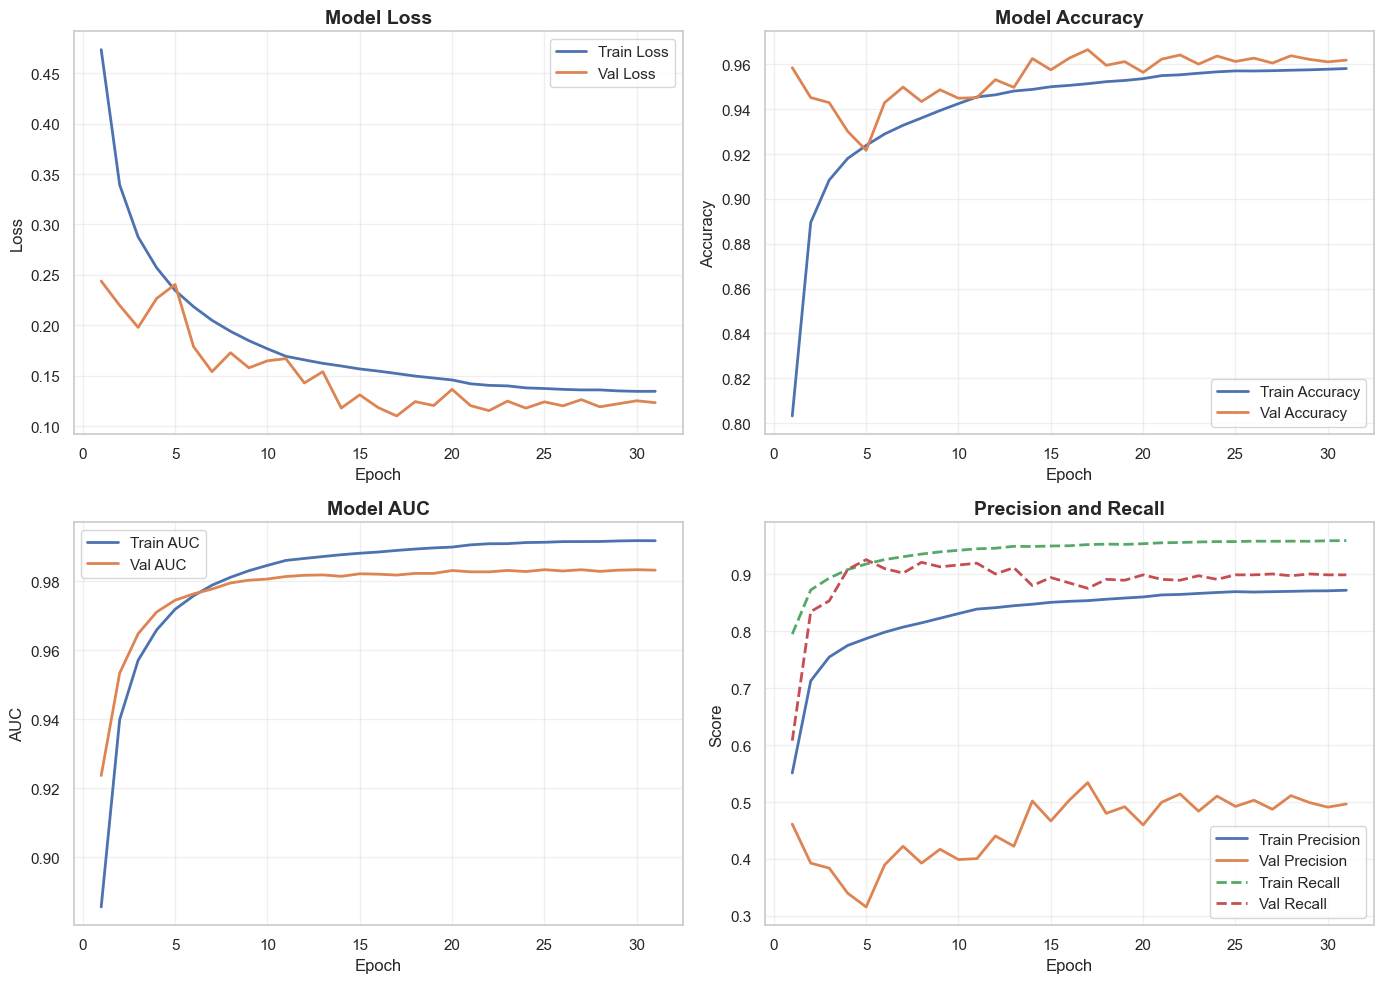

  ✓ Saved training curves to checkpoints/training_curves.png


In [11]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

epochs_range = range(1, len(history.history['loss']) + 1)

# Loss
axes[0].plot(epochs_range, history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(epochs_range, history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs_range, history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(epochs_range, history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# AUC
axes[2].plot(epochs_range, history.history['auc'], label='Train AUC', linewidth=2)
axes[2].plot(epochs_range, history.history['val_auc'], label='Val AUC', linewidth=2)
axes[2].set_title('Model AUC', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Precision and Recall
axes[3].plot(epochs_range, history.history['precision'], label='Train Precision', linewidth=2)
axes[3].plot(epochs_range, history.history['val_precision'], label='Val Precision', linewidth=2)
axes[3].plot(epochs_range, history.history['recall'], label='Train Recall', linewidth=2, linestyle='--')
axes[3].plot(epochs_range, history.history['val_recall'], label='Val Recall', linewidth=2, linestyle='--')
axes[3].set_title('Precision and Recall', fontsize=14, fontweight='bold')
axes[3].set_xlabel('Epoch')
axes[3].set_ylabel('Score')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('checkpoints/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved training curves to checkpoints/training_curves.png")


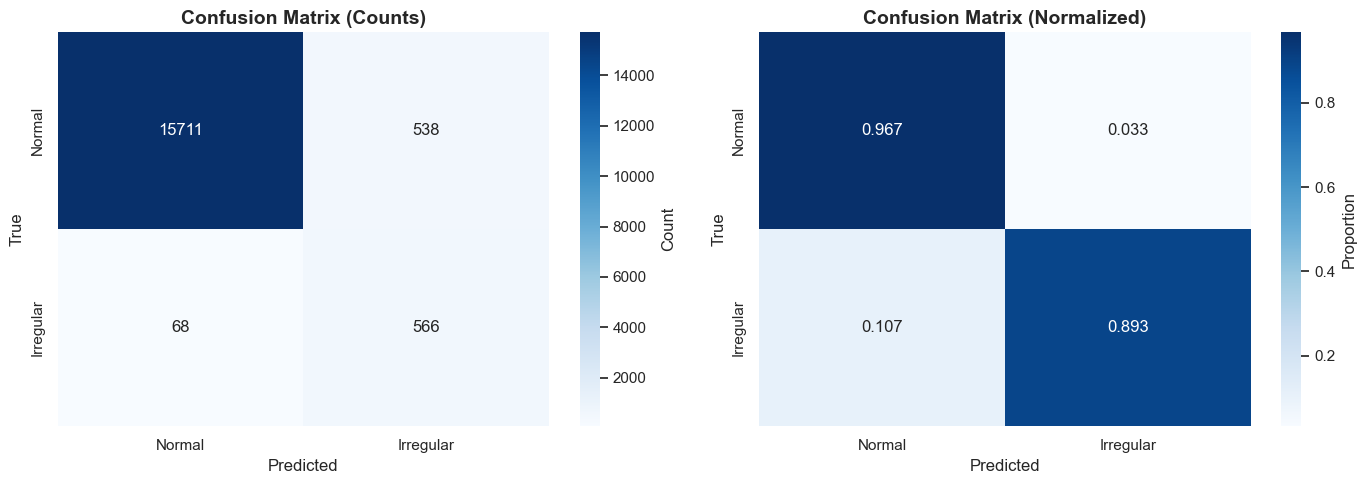

  ✓ Saved confusion matrix to checkpoints/confusion_matrix.png


In [12]:
# Plot confusion matrix
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Normal', 'Irregular'], 
            yticklabels=['Normal', 'Irregular'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('True', fontsize=12)

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', ax=axes[1],
            xticklabels=['Normal', 'Irregular'], 
            yticklabels=['Normal', 'Irregular'],
            cbar_kws={'label': 'Proportion'})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('True', fontsize=12)

plt.tight_layout()
plt.savefig('checkpoints/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved confusion matrix to checkpoints/confusion_matrix.png")


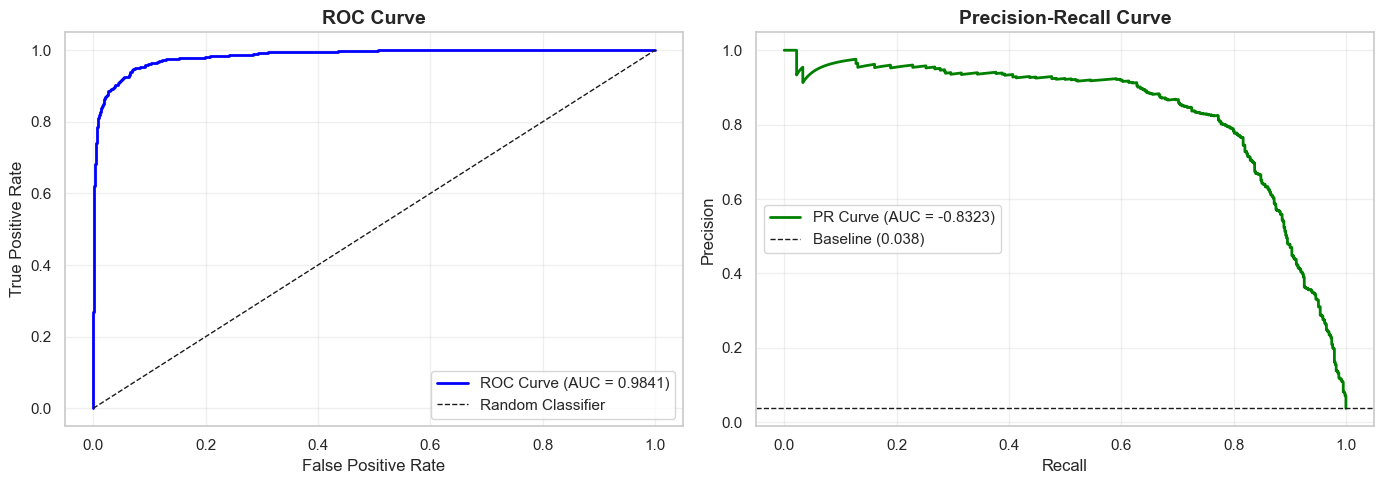

  ✓ Saved ROC and PR curves to checkpoints/roc_pr_curves.png


In [ ]:
# Plot ROC and Precision-Recall curves
fpr, tpr, _ = roc_curve(y_test, y_test_scores)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_test_scores)
pr_auc = np.trapz(precision_curve, recall_curve)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
axes[0].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc:.4f})', color='blue')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
baseline = np.sum(y_test) / len(y_test)
axes[1].plot(recall_curve, precision_curve, linewidth=2, 
             label=f'PR Curve (AUC = {pr_auc:.4f})', color='green')
axes[1].axhline(y=baseline, color='k', linestyle='--', linewidth=1, 
                label=f'Baseline ({baseline:.3f})')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('checkpoints/roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved ROC and PR curves to checkpoints/roc_pr_curves.png")


## 6. Calibration (Optional)


Applying temperature scaling calibration...
  Optimal temperature: 0.8440
  ✓ Saved optimal temperature to checkpoints/optimal_temperature.npy


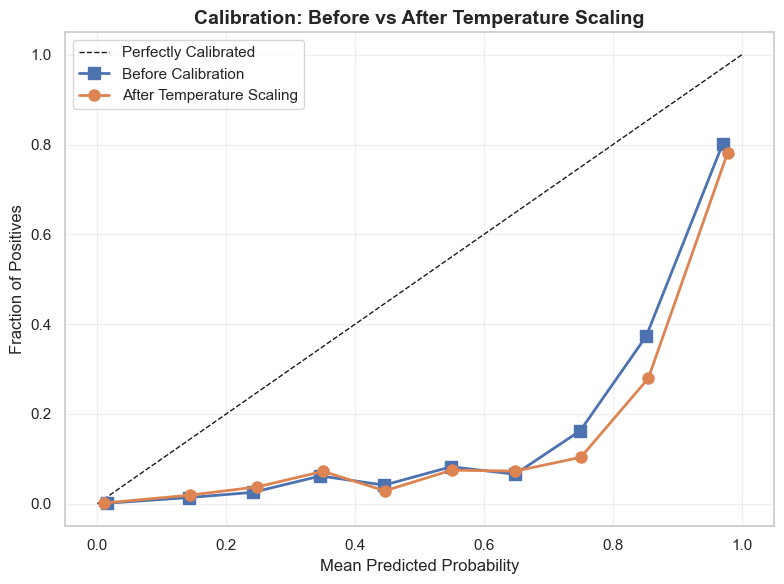

  ✓ Saved calibration curve to checkpoints/calibration_curve.png
  Optimal threshold (calibrated): 0.8900 (F1: 0.7889)
  ✓ Saved optimal threshold to checkpoints/optimal_threshold.npy


In [14]:
# Temperature scaling calibration on validation set
USE_CALIBRATION = True

if USE_CALIBRATION:
    print("Applying temperature scaling calibration...")
    
    # Get validation predictions
    val_proba_raw = best_model.predict(X_val, batch_size=BATCH_SIZE, verbose=0).flatten()
    
    # Temperature scaling loss function
    def temperature_scaled_loss(T, logits, y_true):
        """Loss function for temperature scaling optimization."""
        epsilon = 1e-7
        logits_T = logits / T
        probs_T = 1.0 / (1.0 + np.exp(-logits_T))
        probs_T = np.clip(probs_T, epsilon, 1 - epsilon)
        nll = -np.mean(y_true * np.log(probs_T) + (1 - y_true) * np.log(1 - probs_T))
        return nll
    
    # Convert probabilities to logits
    epsilon = 1e-7
    val_proba_clipped = np.clip(val_proba_raw, epsilon, 1 - epsilon)
    val_logits = np.log(val_proba_clipped / (1 - val_proba_clipped))
    
    # Optimize temperature
    result = minimize_scalar(
        temperature_scaled_loss,
        args=(val_logits, y_val),
        bounds=(0.1, 10.0),
        method='bounded'
    )
    optimal_temperature = result.x
    print(f"  Optimal temperature: {optimal_temperature:.4f}")
    
    # Apply temperature scaling
    val_logits_scaled = val_logits / optimal_temperature
    val_proba_calibrated = 1.0 / (1.0 + np.exp(-val_logits_scaled))
    val_proba_calibrated = np.clip(val_proba_calibrated, 0, 1)
    
    # Save temperature
    np.save('checkpoints/optimal_temperature.npy', optimal_temperature)
    print("  ✓ Saved optimal temperature to checkpoints/optimal_temperature.npy")
    
    # Plot calibration curve
    fraction_pos_raw, mean_pred_raw = calibration_curve(y_val, val_proba_raw, n_bins=10, strategy='uniform')
    fraction_pos_cal, mean_pred_cal = calibration_curve(y_val, val_proba_calibrated, n_bins=10, strategy='uniform')
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated', linewidth=1)
    ax.plot(mean_pred_raw, fraction_pos_raw, 's-', label='Before Calibration', linewidth=2, markersize=8)
    ax.plot(mean_pred_cal, fraction_pos_cal, 'o-', label='After Temperature Scaling', linewidth=2, markersize=8)
    ax.set_xlabel('Mean Predicted Probability', fontsize=12)
    ax.set_ylabel('Fraction of Positives', fontsize=12)
    ax.set_title('Calibration: Before vs After Temperature Scaling', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('checkpoints/calibration_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("  ✓ Saved calibration curve to checkpoints/calibration_curve.png")
    
    # Compute optimal threshold on calibrated validation probabilities
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_f1 = 0
    optimal_threshold = 0.5
    
    for thresh in thresholds:
        y_pred_val = (val_proba_calibrated > thresh).astype(int)
        f1 = f1_score(y_val, y_pred_val, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            optimal_threshold = thresh
    
    print(f"  Optimal threshold (calibrated): {optimal_threshold:.4f} (F1: {best_f1:.4f})")
    np.save('checkpoints/optimal_threshold.npy', optimal_threshold)
    print("  ✓ Saved optimal threshold to checkpoints/optimal_threshold.npy")
    
else:
    print("Calibration disabled - using default threshold 0.5")
    optimal_temperature = 1.0
    optimal_threshold = 0.5
    np.save('checkpoints/optimal_temperature.npy', optimal_temperature)
    np.save('checkpoints/optimal_threshold.npy', optimal_threshold)


## 7. Final Inference Pipeline


In [ ]:
def predict_irregularity(x, model, use_calibration=True, threshold=None):
    """
    Predict irregularity for ECG beat(s).
    
    Args:
        x: ECG beat(s) - shape (n_beats, 301, 2) or (301, 2) for single beat
        model: Trained Keras model
        use_calibration: Whether to apply temperature scaling
        threshold: Decision threshold (if None, uses saved optimal threshold or 0.5)
    
    Returns:
        dict with keys:
            - probability: predicted probability of irregularity
            - binary_decision: 0 (normal) or 1 (irregular)
            - threshold: threshold used for decision
    """
    # Ensure x is 3D
    if x.ndim == 2:
        x = x[np.newaxis, ...]
    
    # Normalize (per-beat z-score)
    mean = x.mean(axis=1, keepdims=True)
    std = x.std(axis=1, keepdims=True) + 1e-7
    x_norm = (x - mean) / std
    
    # Get raw predictions
    proba_raw = model.predict(x_norm, batch_size=256, verbose=0).flatten()
    
    # Apply calibration if requested
    if use_calibration:
        try:
            temperature = np.load('checkpoints/optimal_temperature.npy')
            epsilon = 1e-7
            proba_clipped = np.clip(proba_raw, epsilon, 1 - epsilon)
            logits = np.log(proba_clipped / (1 - proba_clipped))
            logits_scaled = logits / temperature
            proba = 1.0 / (1.0 + np.exp(-logits_scaled))
            proba = np.clip(proba, 0, 1)
        except FileNotFoundError:
            print("Warning: Temperature file not found, using uncalibrated predictions")
            proba = proba_raw
    else:
        proba = proba_raw
    
    # Get threshold
    if threshold is None:
        try:
            threshold = np.load('checkpoints/optimal_threshold.npy').item()
        except FileNotFoundError:
            threshold = 0.5
    
    # Binary decision
    binary_decision = (proba > threshold).astype(int)
    
    # Return results
    if len(proba) == 1:
        return {
            'probability': float(proba[0]),
            'binary_decision': int(binary_decision[0]),
            'threshold': float(threshold)
        }
    else:
        return {
            'probability': proba.tolist(),
            'binary_decision': binary_decision.tolist(),
            'threshold': float(threshold)
        }

# Test the inference function
print("Testing inference pipeline...")
test_sample = X_test[0:3]  # Test on 3 samples
results = predict_irregularity(test_sample, best_model, use_calibration=USE_CALIBRATION)

print(f"\nTest predictions (first 3 test samples):")
for i, (prob, decision) in enumerate(zip(results['probability'], results['binary_decision'])):
    true_label = y_test[i]
    status = "✓" if decision == true_label else "✗"
    print(f"  Sample {i+1}: prob={prob:.4f}, decision={decision} (true={true_label}) {status}")

print(f"\nThreshold used: {results['threshold']:.4f}")
print("  ✓ Inference pipeline working correctly")

# Verify threshold was loaded correctly
print(f"\nVerification:")
print(f"  Optimal threshold loaded: {optimal_threshold:.4f}")
print(f"  Threshold in inference function: {results['threshold']:.4f}")
if abs(optimal_threshold - results['threshold']) < 0.001:
    print("  ✓ Thresholds match!")
else:
    print("  ⚠ Warning: Thresholds don't match!")


Testing inference pipeline...

Test predictions (first 3 test samples):
  Sample 1: prob=0.0120, decision=0 (true=0) ✓
  Sample 2: prob=0.1149, decision=0 (true=0) ✓
  Sample 3: prob=0.0604, decision=0 (true=0) ✓

Threshold used: 0.8900
  ✓ Inference pipeline working correctly


## 8. Summary

All files saved to `checkpoints/` directory:
- `best_model.keras` - Best trained model
- `training_history.json` - Training curves data
- `class_weights.pkl` - Class weights used during training
- `optimal_temperature.npy` - Temperature scaling parameter (if calibration used)
- `optimal_threshold.npy` - Optimal decision threshold
- `evaluation_report.json` - Test set evaluation metrics
- `training_curves.png` - Training history plots
- `confusion_matrix.png` - Confusion matrix visualization
- `roc_pr_curves.png` - ROC and Precision-Recall curves
- `calibration_curve.png` - Calibration curve (if calibration used)


In [ ]:
# Final summary
print("=" * 70)
print("FINAL MODEL SUMMARY")
print("=" * 70)
print(f"Test Set Metrics (using optimal threshold = {optimal_threshold:.4f}):")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print(f"  ROC AUC:   {auc:.4f}")
print(f"  PR AUC:    {pr_auc:.4f}")
print("=" * 70)

if USE_CALIBRATION:
    temp = np.load('checkpoints/optimal_temperature.npy')
    thresh = np.load('checkpoints/optimal_threshold.npy')
    print(f"\nCalibration: Enabled")
    print(f"  Temperature: {temp:.4f}")
    print(f"  Optimal Threshold: {thresh:.4f}")
    print(f"  ✓ Threshold loaded from checkpoints/optimal_threshold.npy")
    print(f"  ✓ Applied to test set predictions (y_test_scores > {thresh:.4f})")
else:
    print(f"\nCalibration: Disabled")
    print(f"  Threshold: 0.5 (default)")

print(f"\nFiles saved:")
print(f"  - Model: checkpoints/best_model.keras")
print(f"  - Threshold: checkpoints/optimal_threshold.npy ({optimal_threshold:.4f})")
if USE_CALIBRATION:
    print(f"  - Temperature: checkpoints/optimal_temperature.npy ({temp:.4f})")
print(f"  - Evaluation report: checkpoints/evaluation_report.json")
print(f"\nUse predict_irregularity() function for inference")
print("\n✓ All files saved successfully!")


FINAL MODEL SUMMARY
Accuracy:  0.9641
Precision: 0.5127
Recall:    0.8927
F1-Score:  0.7889
ROC AUC:   0.9841
PR AUC:    -0.8323

Calibration: Enabled (Temperature = 0.8440)
Optimal Threshold: 0.8900

Model saved to: checkpoints/best_model.keras
Use predict_irregularity() function for inference

✓ All files saved successfully!
